In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
df = pd.read_csv('task_3_event_prediction.tsv', sep='\t', header=0, low_memory=False, skip_blank_lines=True)
df = df[df['EVENT_TYPE'].notna()]
df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'])
df.sort_values('EVENT_DATE', inplace=True)

In [ ]:
info ={}
for ele in range(len(df)):
  try:
    date = str(df.loc[ele, 'EVENT_DATE'])
    if str(df.loc[ele, 'EVENT_TYPE']) == 'Protests':
        if date in info:
          info[date] += 1
        else:
          info[date] = 1
  except KeyError:
    pass
    
df2 = pd.DataFrame({'EVENT_DATE':info.keys(), 'PROTEST_COUNT':info.values()})
df2['EVENT_DATE'] = pd.to_datetime(df2['EVENT_DATE'])
df2 = df2.sort_values('EVENT_DATE')

In [ ]:
info ={}
for ele in range(len(df)):
  try:
    date = str(df.loc[ele, 'EVENT_DATE'])
    if date in info:
      info[date] += str(df.loc[ele, 'NOTES'])
    else:
      info[date] = str(df.loc[ele, 'NOTES'])
  except KeyError:
    pass

df3 = pd.DataFrame({'EVENT_DATE':info.keys(), 'PROTEST_COUNT':df2['PROTEST_COUNT']})
df3['EVENT_DATE'] = pd.to_datetime(df3['EVENT_DATE'])
df3 = df3.sort_values('EVENT_DATE')
df3 = df3.astype({'EVENT_DATE':str, 'PROTEST_COUNT':int} )


In [ ]:
data = df3.sort_values('EVENT_DATE')

In [ ]:
data

,EVENT_DATE,PROTEST_COUNT
0,2018-01-01,19
1,2018-01-02,36
2,2018-01-03,44
3,2018-01-04,22
4,2018-01-05,30
...,...,...
1477,2022-01-17,86
1478,2022-01-18,55
1479,2022-01-19,45
1480,2022-01-20,54


In [ ]:
count = data[['PROTEST_COUNT']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
count['PROTEST_COUNT'] = scaler.fit_transform(count['PROTEST_COUNT'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
def make_list(input):
  final = [[input[0][0]]]
  for i in range(1, len(input)):
    final.append([input[i][0]])
  return final

def split_series(series, n_past, n_future):

  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  in_count, tgt_count = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    in_counts_w, tgt_counts_w = make_list(series[window_start:past_end]), [series[future_end-1][0]]
    in_count.append(in_counts_w)
    tgt_count.append(tgt_counts_w)
  return in_count, tgt_count

In [ ]:
hist = 3
future = 1

input, tgt = split_series(count.values, hist, future)
train_len = int(len(input)*.8)

x_train = input[:train_len]
y_train = tgt[:train_len]
x_test = input[train_len:]
y_test = tgt[train_len:]

In [ ]:
import torch
import torch.nn as nn

x_train = torch.tensor(x_train).type(torch.Tensor)
x_test = torch.tensor(x_test).type(torch.Tensor)
y_train = torch.tensor(y_train).type(torch.Tensor)
y_test = torch.tensor(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 4
output_dim = 1
num_epochs = 50
dropout = 0.2
bidirectional = True

In [ ]:
class LSTM(nn.Module):
    def __init__(self, in_features, embeddings=32, layers=4, dropout=0.2, bidirectional=True):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim*2, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(torch.cat([hn[-2,:,:], hn[-1,:,:]], -1))
        return self.fc(out)



In [ ]:
model = LSTM(input_dim, hidden_dim, 4, 0.2, True)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 2e-5)

In [ ]:
def r_squared(preds, y):
  n = torch.sum((y - preds)**2)
  mean_value = torch.mean(y)
  d = torch.sum((y - mean_value)**2)
  return (1.0 - (d/n))


In [ ]:
hist = np.zeros(num_epochs)

model.train()
loss_track = []
for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    loss_track.append(loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()


In [ ]:
model.eval()

y_test_pred = model(x_test)


In [ ]:
r_squared(y_test_pred, y_test)

tensor(0.9806, grad_fn=<RsubBackward1>)

In [ ]:
loss_track2 = loss_track[:]

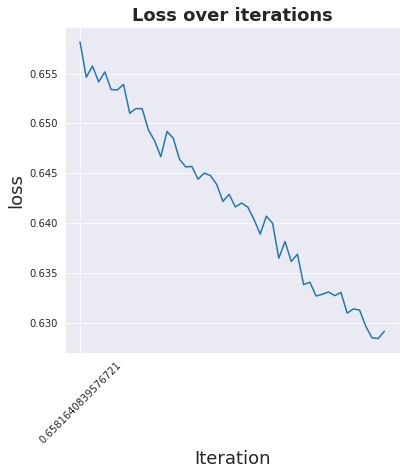

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (6,6))
plt.plot(loss_track2)
plt.xticks(range(0,len(loss_track2),500),loss_track2,rotation=45)
plt.title("Loss over iterations",fontsize=18, fontweight='bold')
plt.xlabel('Iteration',fontsize=18)
plt.ylabel('loss',fontsize=18)
plt.show()